# Calibrate the two cameras

In [41]:
# from https://github.com/niconielsen32/ComputerVision/blob/master/cameraCalibration.py
# modified
import scipy
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import glob

img_path = 'assets/calibration/'
np.set_printoptions(precision=9,suppress=True)

################ FIND CHESSBOARD CORNERS - OBJECT POINTS AND IMAGE POINTS #############################

chessboardSize = (7,7)
frameSize = (1600,1200)

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

def calibrate(file_selector, index, out_path):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)

    size_of_chessboard_squares_mm = 20
    objp = objp * size_of_chessboard_squares_mm


    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.


    images = glob.glob(img_path + file_selector + "-*.jpg")

    for image in images:

        img = cv.imread(image)
        img = cv.resize(img, frameSize)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, chessboardSize, None)

        # If found, add object points, image points (after refining them)
        print(ret)
        if ret == True:

            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners)


    ############## CALIBRATION #######################################################

    ret, cameraMatrix, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, frameSize, None, None)

    #print("ImgPoints: ", imgpoints)

    print('')

    print("Camera calibrated: ", ret)
    print("Camera Matrix: ", cameraMatrix)
    print("Distortion Parameters: ", dist)
    print("Rotation Vectors: ", rvecs)
    print("Translation Vectors: ", tvecs)
    
    # ===========================  Calculate P  ==============================
    R = cv.Rodrigues(rvecs[index])[0]
    t = tvecs[index]
    W = np.concatenate([R,t], axis=-1) # [R|t]
    K = cameraMatrix
    P = K.dot(W)
    print('P for '+ file_selector + str(index))
    print(P)
    return P,cameraMatrix


    ############## UNDISTORTION #####################################################

    #img = cv.imread(img_path + file_selector + "-0" + str(index+1) + ".jpg")
    #h,  w = img.shape[:2]
    #newCameraMatrix, roi = cv.getOptimalNewCameraMatrix(cameraMatrix, dist, (w,h), 1, (w,h))


    # Undistort
    #dst = cv.undistort(img, cameraMatrix, dist, None, newCameraMatrix)

    # crop the image
    #x, y, w, h = roi
    #dst = dst[y:y+h, x:x+w]
    #cv.imwrite(out_path, dst)



# Undistort with Remapping
#mapx, mapy = cv.initUndistortRectifyMap(cameraMatrix, dist, None, newCameraMatrix, (w,h), 5)
#dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

# crop the image
#x, y, w, h = roi
#dst = dst[y:y+h, x:x+w]
#cv.imwrite('caliResult2.png', dst)




# Reprojection Error
#mean_error = 0

#for i in range(len(objpoints)):
#    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], cameraMatrix, dist)
#    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
#    mean_error += error

#print( "total error: {}".format(mean_error/len(objpoints)) )


In [43]:
P, K1 = calibrate("left", 3, "assets/left.jpg")
Pp, K2 = calibrate("right", 3, "assets/right.jpg")
(P,Pp)

True
True
True
True
True
True
True
True
True
True

Camera calibrated:  1.164967173339667
Camera Matrix:  [[977.494039664   0.          921.896335544]
 [  0.          976.287578756 601.63782338 ]
 [  0.            0.            1.         ]]
Distortion Parameters:  [[-0.316249157  0.534652887  0.03410252  -0.010146128 -0.437756357]]
Rotation Vectors:  (array([[0.046741896],
       [0.132079098],
       [0.84696031 ]]), array([[-0.041560764],
       [ 0.043126274],
       [ 0.321795239]]), array([[0.061468391],
       [1.025530772],
       [1.112931212]]), array([[-0.280761977],
       [ 0.344003885],
       [ 1.370476869]]), array([[ 0.054054817],
       [-0.008759377],
       [ 0.099938338]]), array([[ 0.02668436 ],
       [-0.090625095],
       [ 0.27041739 ]]), array([[-0.119201696],
       [-0.321194311],
       [ 0.058708343]]), array([[0.010443901],
       [0.039420257],
       [3.128256683]]), array([[-0.031523768],
       [-0.005089134],
       [ 0.082023374]]), array([[-0.02726

(array([[  -207.810101005,   -957.53264739 ,    919.420275048,
         499058.537873731],
        [   641.846642823,    177.844561471,    933.546841892,
         625080.797196914],
        [    -0.398103114,      0.004433558,      0.917329959,
            776.363780947]]),
 array([[   612.430485549,   -929.557380308,    804.197963442,
         998847.540699963],
        [   835.836177431,    546.965600104,    629.515655944,
         476432.545897397],
        [     0.000388   ,     -0.116635373,      0.993174727,
            788.766676859]]))

Tcv [[ 0.24176438]
 [-0.30425413]
 [-0.92139999]
 [ 0.00121441]]
Tf [-533591.93324662  562996.69278634 -195193.24444123]
Sanity (P) [[-2.07810101e+02 -9.57532647e+02  9.19420275e+02  4.99058538e+05]
 [ 6.41846643e+02  1.77844561e+02  9.33546842e+02  6.25080797e+05]
 [-3.98103114e-01  4.43355772e-03  9.17329959e-01  7.76363781e+02]]
Sanity (K) [[-2.07810101e+02 -9.57532647e+02  9.19420275e+02 -7.01530871e+08]
 [ 6.41846643e+02  1.77844561e+02  9.33546842e+02  4.32211039e+08]
 [-3.98103114e-01  4.43355772e-03  9.17329959e-01 -1.95193244e+05]]
C [ 199.07971113 -250.53659169 -758.72236869]
Tcv [[ 0.22641046]
 [-0.35002186]
 [ 0.90896731]
 [-0.00119639]]
Tf [ 212305.33395763 1084736.05567917  -54397.95205922]
Sanity (P) [[ 6.12430486e+02 -9.29557380e+02  8.04197963e+02  9.98847541e+05]
 [ 8.35836177e+02  5.46965600e+02  6.29515656e+02  4.76432546e+05]
 [ 3.87999651e-04 -1.16635373e-01  9.93174727e-01  7.88766677e+02]]
Sanity (K) [[ 6.12430486e+02 -9.29557380e+02  8.04197963e+02  1.69487620e

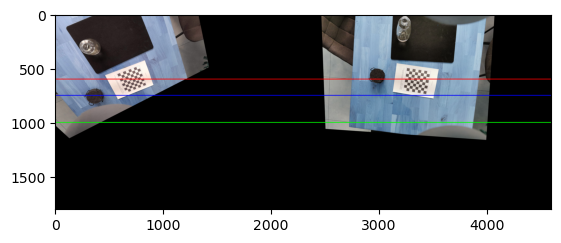

In [37]:
def factorize(P):
    M = P[:,0:3]
    
    out = cv.decomposeProjectionMatrix(P)
    K,R,T = out[0],out[1],out[2]
    K = K / K[2,2]
    print("Tcv", T)
    T = R.dot(P[:,3])
    print("Tf", T)
    
    C = np.dot(-scipy.linalg.inv(M),P[:,3])
    print("Sanity (P)", P) 
    print("Sanity (K)", K.dot(np.concatenate((R,T.reshape(-1,1)), axis=1)))
    print("C", C)
    return(K,R,C)

def plotLine(img, height, color):
    cv.line(img, (0,height), (4600,height), color, 5)

def fusiello(Mpl,Mpr, imgL_path, imgR_path, out_path=None):  
    Kl,Rl,Cl = factorize(Mpl)
    Kr,Rr,Cr = factorize(Mpr)
    print(Kl)
    print(Rl)
    print(Cl)
    x = Cl-Cr
    y = np.array(x)
    y[0]=-x[1]
    y[1]=x[0]
    z = np.cross(x,y)
    print("x", x)
    print("y", y)
    x = x/np.linalg.norm(x)
    y = y/np.linalg.norm(y)
    z = z/np.linalg.norm(z)
    Rs = np.array([x,y,z])
    tls = -Rs.dot(Cl).reshape(-1,1)
    trs = -Rs.dot(Cr).reshape(-1,1)
    print("Rs", Rs)
    print(tls)
    print(trs)
    #print(Rs)
    Ks = (Kl+Kr)/2
    Ks[0,1]=0
    Mls = Ks.dot(np.concatenate((Rs, tls), axis=1))
    Mrs = Ks.dot(np.concatenate((Rs, trs), axis=1))
    print("Mrs",Mrs)
    print("Mls",Mls)
    TFusl = Ks.dot(Rs).dot(np.linalg.inv(Kl.dot(Rl)))
    TFusr = Ks.dot(Rs).dot(np.linalg.inv(Kr.dot(Rr)))
    print("TFusl",TFusl)
    print("TFusr",TFusr)
    
    imgL=cv.imread(imgL_path)
    imgL = cv.resize(imgL,(1600,1200))
    imgR=cv.imread(imgR_path)
    imgR = cv.resize(imgR,(1600,1200))
    
    #cv.warpPerspective(imgL)
    outL = cv.warpPerspective(imgL,TFusl,(2300,1800),flags=cv.INTER_LINEAR)
    outR = cv.warpPerspective(imgR,TFusr,(2300,1800),flags=cv.INTER_LINEAR)
    out = cv.hconcat([outL,outR])
    plotLine(out, 600, (255, 0, 0))
    plotLine(out, 750, (0, 0, 255))
    plotLine(out, 1000, (0, 255, 0))
    if(out_path):
        cv.imwrite(out_path, out)
    plt.imshow(out)
    
    
fusiello(P, Pp, "assets/calibration/left-04.jpg", "assets/calibration/right-04.jpg", 'assets/fusiello.jpg')

In [29]:
Pp = np.array([[ 6.12430486e+02, -9.29557380e+02,  8.04197963e+02,
         9.98847541e+05],
       [ 8.35836177e+02,  5.46965600e+02,  6.29515656e+02,
         4.76432546e+05],
       [ 3.87999651e-04, -1.16635373e-01,  9.93174727e-01,
         7.88766677e+02]])
P = np.array([[-2.07810101e+02, -9.57532647e+02,  9.19420275e+02,
         4.99058538e+05],
       [ 6.41846643e+02,  1.77844561e+02,  9.33546842e+02,
         6.25080797e+05],
       [-3.98103114e-01,  4.43355772e-03,  9.17329959e-01,
         7.76363781e+02]])



print("P\n",P)
print("Pp\n",Pp)

P
 [[-2.07810101e+02 -9.57532647e+02  9.19420275e+02  4.99058538e+05]
 [ 6.41846643e+02  1.77844561e+02  9.33546842e+02  6.25080797e+05]
 [-3.98103114e-01  4.43355772e-03  9.17329959e-01  7.76363781e+02]]
Pp
 [[ 6.12430486e+02 -9.29557380e+02  8.04197963e+02  9.98847541e+05]
 [ 8.35836177e+02  5.46965600e+02  6.29515656e+02  4.76432546e+05]
 [ 3.87999651e-04 -1.16635373e-01  9.93174727e-01  7.88766677e+02]]
